<a href="https://www.kaggle.com/code/suchitg04/tv-and-desktop-monitor-classifier-chap1?scriptVersionId=127047579" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### This model classifies flat screen TVs, CRT TVs and desktop monitors with a decent accuracy

I learnt a fair bit of stuff about Jupyter notebooks and getting help from documentation. This is very encouraging seeing results right in the first lecture!

In [18]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [19]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [20]:
?L.itemgot

Signature: L.itemgot(self, *idxs)
Docstring: Create new `L` with item `idx` of all `items`
File:      /opt/conda/lib/python3.7/site-packages/fastcore/foundation.py
Type:      function


In [21]:
urls = search_images('flat screen tv', max_images=1)
urls[0]

Searching for 'flat screen tv'


'http://images.consumerreports.org/production/products/testedmodel/profile/cr/jpg/598/375980-lcdledoledplasmatvs-lg-24lf4520.jpg'

In [22]:
from fastdownload import download_url
dest = 'flatscreentv.jpg'
download_url(urls[0], dest, show_progress=False)

Path('flatscreentv.jpg')

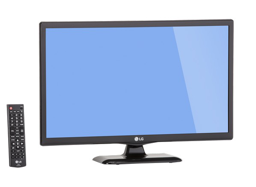

In [23]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [24]:
?download_url

Signature: download_url(url, dest=None, timeout=None, show_progress=True)
Docstring: Download `url` to `dest` and show progress
File:      /opt/conda/lib/python3.7/site-packages/fastdownload/core.py
Type:      function


Searching for 'crt tv'


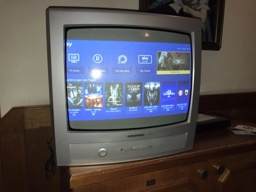

In [25]:
download_url(search_images('crt tv', max_images=1)[0], 'crttv.jpg', show_progress=False)
Image.open('crttv.jpg').to_thumb(256, 256)

In [26]:
?Path

Init signature: Path(*args, **kwargs)
Docstring:     
PurePath subclass that can make system calls.

Path represents a filesystem path but unlike PurePath, also offers
methods to do system calls on path objects. Depending on your system,
instantiating a Path will return either a PosixPath or a WindowsPath
object. You can also instantiate a PosixPath or WindowsPath directly,
but cannot instantiate a WindowsPath on a POSIX system or vice versa.
File:           /opt/conda/lib/python3.7/pathlib.py
Type:           type
Subclasses:     PosixPath, WindowsPath


In [27]:
?mkdir

Signature: mkdir(path, exist_ok=False, parents=False, overwrite=False, **kwargs)
Docstring: Creates and returns a directory defined by `path`, optionally removing previous existing directory if `overwrite` is `True`
File:      /opt/conda/lib/python3.7/site-packages/fastcore/xtras.py
Type:      function


In [28]:
?resize_images

Signature:
resize_images(
    path,
    max_workers=2,
    max_size=None,
    recurse=False,
    dest=Path('.'),
    n_channels=3,
    ext=None,
    img_format=None,
    resample=<Resampling.BILINEAR: 2>,
    resume=None,
    **kwargs,
)
Docstring: Resize files on path recursively to dest to max_size
File:      /opt/conda/lib/python3.7/site-packages/fastai/vision/utils.py
Type:      function


In [29]:
searches = 'flat screen tv', 'crt tv', 'desktop monitor'
path = Path('tv_or_desktop')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(o))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'flat screen tv'
Searching for 'crt tv'
Searching for 'desktop monitor'


In [30]:
?Path.unlink

Signature: Path.unlink(self)
Docstring:
Remove this file or link.
If the path is a directory, use rmdir() instead.
File:      /opt/conda/lib/python3.7/pathlib.py
Type:      function


In [31]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

In [32]:
?parent_label

Signature: parent_label(o)
Docstring: Label `item` with the parent folder name.
File:      /opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py
Type:      function


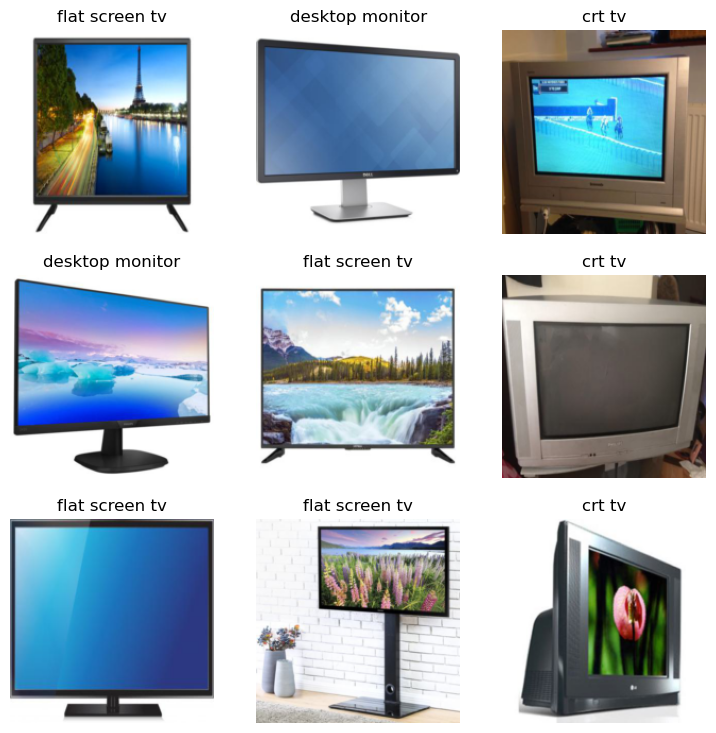

In [33]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=9)

In [34]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.929003,2.417075,0.764706,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.410291,1.448335,0.588235,00:01
1,1.121018,0.641081,0.235294,00:01
2,0.785384,0.340891,0.117647,00:01
3,0.609821,0.239983,0.117647,00:01
4,0.488854,0.242259,0.058824,00:01


In [35]:
learn.predict(PILImage.create('crttv.jpg'))

('crt tv', tensor(0), tensor([0.9883, 0.0105, 0.0012]))

In [36]:
learn.predict(PILImage.create('flatscreentv.jpg'))

('flat screen tv', tensor(2), tensor([0.0012, 0.0750, 0.9238]))

Searching for 'desktop monitor'


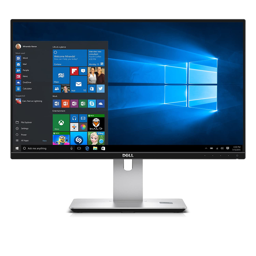

In [37]:
download_url(search_images('desktop monitor', max_images=1)[0], dest='desktopmonitor.jpg', show_progress=False)
Image.open('desktopmonitor.jpg').to_thumb(256, 256)

In [38]:
learn.predict(PILImage.create('desktopmonitor.jpg'))

('desktop monitor', tensor(1), tensor([6.7485e-05, 9.9748e-01, 2.4550e-03]))